In [1]:
!pip install tensorflow==2.10.0

In [2]:
import tensorflow as tf

In [3]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from keras.layers import Flatten, Input, Dense, Dropout

In [4]:
sklearn.__version__

'1.2.2'

In [5]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
!pip install transformers
from transformers import DistilBertTokenizer, TFDistilBertModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.4 MB/s eta 0:00:00


In [7]:
import transformers
transformers.__version__

'4.33.1'

In [8]:
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [9]:
# Load dataset
df = pd.read_csv("Final_preprocessed_dataset_portuguese.csv")
#df.fillna('', inplace=True)

In [10]:
# Split data into train and test sets
X = df['Text'].values
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Convert the model to a mobile version and optimize it

In [11]:
# Define the custom objects
custom_objects = {
    'TFDistilBertModel': TFDistilBertModel,
}

# Load the model with custom objects
model = load_model('dir_model_DistilBERT_92_portuguese', custom_objects=custom_objects)

# Build the model before converting
model.build(input_shape=(None, 128))

# Convert the model to TensorFlow Lite format with optimization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the optimized model to a file
with open('mobile_portuguese_distilBERT_optimized.tflite', 'wb') as f:
    f.write(tflite_model)


Test model with test data

In [12]:
with open('X_test_tokenized_distilBERT_uncased_portuguese.pkl', 'rb') as f:
    X_test_tokenized = pickle.load(f)

X_test_input_ids = X_test_tokenized['input_ids']

In [13]:
interpreter = tf.lite.Interpreter(model_path='mobile_portuguese_distilBERT_optimized.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

y_pred_test = []
for input_ids in X_test_input_ids:
    input_data = np.expand_dims(input_ids, axis=0)  # Expand dimensions to match the expected shape
    input_data = np.array(input_data, dtype=np.int32)  # Convert input_ids to INT32

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    y_pred_test.append(output_data)

y_pred_test = np.concatenate(y_pred_test, axis=0)


In [14]:
# Save y_pred_test
np.save('y_pred_test_portuguese_DistilBERT_mobile_optimized.npy', y_pred_test)

In [15]:
# Load y_pred_test
y_pred_test = np.load('y_pred_test_portuguese_DistilBERT_mobile_optimized.npy')

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      6285
           1       0.92      0.93      0.92      6363

    accuracy                           0.92     12648
   macro avg       0.92      0.92      0.92     12648
weighted avg       0.92      0.92      0.92     12648



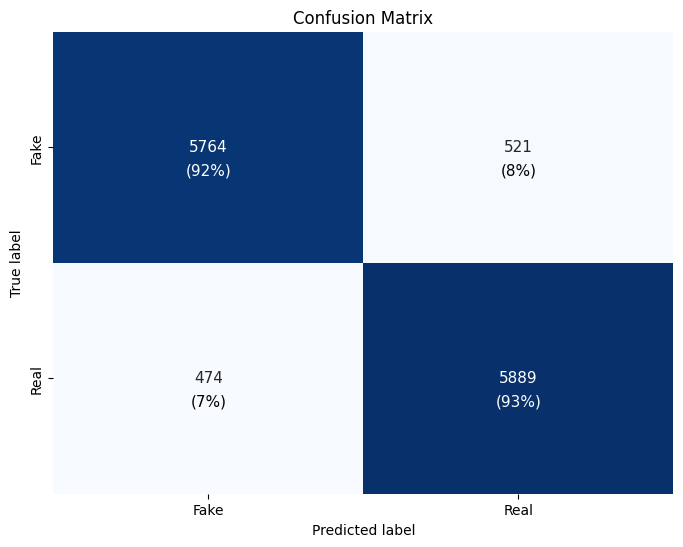

In [16]:
# Apply thresholding to obtain binary predictions
threshold = 0.5
y_pred_binary = np.where(y_pred_test >= threshold, 1, 0)

# Calculate the F1-score
f1 = f1_score(y_test, y_pred_binary)

# Print the classification report
print(classification_report(y_test, y_pred_binary))

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_binary)

# Compute normalized values
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                 xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'], annot_kws={"fontsize": 11})

# Add normalized values below the actual values
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        text_color = 'black' if conf_mat_norm[i, j] < 0.5 else 'white'
        ax.text(j + 0.5, i + 0.6, f'({conf_mat_norm[i, j]:.0%})', ha='center', va='center', color=text_color, fontsize=11)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()